In [406]:
%load_ext autoreload
%autoreload 2
import io, os, re, logging, sys

sys.path.append("../")

import requests, tqdm, tarfile, itertools, html, time
from dateparser.date import DateDataParser
from dateparser import parse
from fuzzywuzzy import process, fuzz

import numpy as np
import pandas as pd
import dask.dataframe as dd

import torch
import torch.nn.functional as F
import pyro
import pyro.distributions as dist

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn import linear_model, metrics, ensemble, tree, gaussian_process

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt

from src.visualization.visualize import visualize_shot
from src.features.categorical import *
from src.transformations import *
from src.features import *
from src.model.utils import *
from src.model.autoencoder import ShotsAutoEncForecast

import tsa
from tsa.model import AutoEncForecast
from tsa.config import config

from pytorch_forecasting.data.timeseries import TimeSeriesDataSet

import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import loggers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Dataset

In [138]:
shots_df = pd.read_parquet("../data/raw/visualizercoffee_73202shots_2021-12-30_cleaned.parquet")
shots_df.shape

(73202, 37)

## Data transformations

In [422]:
shots_df["yield_ratio"] = shots_df["drink_weight"] / shots_df["bean_weight"]

max_espresso_weight = shots_df["espresso_weight"].apply(lambda x: max(x) if x is not None else None).replace({0: np.NaN})
shots_df["drink_weight"].fillna(max_espresso_weight)

shots_df["max_pressure"] = shots_df["espresso_pressure"].apply(np.max)
shots_df["max_flow"] = shots_df["espresso_flow"].apply(np.max)
shots_df["max_pressure_goal"] = shots_df["espresso_pressure_goal"].apply(np.max)
shots_df["max_flow_goal"] = shots_df["espresso_flow_goal"].apply(np.max)
shots_df['preinfusion_duration'] = shots_df[["timeframe", "espresso_flow_weight"]].apply(preinfusion_time, axis=1)

shots_df["median_temperature"] = shots_df["espresso_temperature_basket"].apply(np.median)
shots_df["mean_resistance"] = shots_df["espresso_resistance"].apply(lambda x: np.mean(x) if x is not None else None)

if not pd.api.types.is_numeric_dtype(shots_df["roast_level"]):
    shots_df["roast_agtron"] = shots_df["roast_level"]
    shots_df["roast_level"] = agtron_to_roast_level(shots_df["roast_level"])
    
shots_df["grinder_setting"] = shots_df.groupby('grinder_model')['grinder_setting'].apply(lambda x: (x-min(x))/(max(x)-min(x)))

In [423]:
shots_df.columns

Index(['id', 'profile_title', 'user_id', 'drink_tds', 'drink_ey',
       'espresso_enjoyment', 'bean_weight', 'drink_weight', 'grinder_model',
       'grinder_setting', 'bean_brand', 'bean_type', 'roast_date',
       'espresso_notes', 'roast_level', 'bean_notes', 'start_time',
       'image_preview', 'profile_url', 'timeframe', 'espresso_flow',
       'espresso_weight', 'espresso_pressure', 'espresso_flow_goal',
       'espresso_resistance', 'espresso_flow_weight', 'espresso_state_change',
       'espresso_pressure_goal', 'espresso_flow_weight_raw',
       'espresso_temperature_mix', 'espresso_water_dispensed',
       'espresso_temperature_goal', 'espresso_resistance_weight',
       'espresso_temperature_basket', 'duration', 'user_name', 'bean_age',
       'yield_ratio', 'max_pressure', 'max_flow', 'max_pressure_goal',
       'max_flow_goal', 'median_temperature', 'mean_resistance',
       'preinfusion_duration'],
      dtype='object')

# Autoencoder for time series

## Build dataset

In [433]:
top_profiles = dataset["profile_title"].value_counts()
top_profiles = top_profiles[top_profiles>1]
top_profiles = top_profiles.head(20)
top_profiles

Best practice (medium roast)     284
Damian's LRv2                    258
Adaptive (for medium roasts)     251
Damian's LRv3                    226
Londonium                        220
Default                          215
Damian's LRv3rs                  198
Blooming Espresso                152
Rao Allongé                      130
Nu Skool Espresso v3              79
Saved                             71
Gentle and sweet                  69
Best overall pressure profile     65
DEK/Blooming Espresso             63
Damian's LRv2 36                  62
D-Flow / default                  54
DEK/Londonium                     41
Damian's LRv2 Edit                41
Idan's Strega Plus/Medium         40
Filter 2.0                        39
Name: profile_title, dtype: int64

In [434]:
shots_training = shots_df[#shots_df["grinder_model"].isin(["Niche Zero"]) & \
                          shots_df["grinder_setting"].notnull() & \
                          ((shots_df["drink_weight"] > 10) & (shots_df["drink_weight"] < 250)) &\
                          shots_df["bean_weight"].notnull() &\
                          shots_df["bean_age"].notnull() &\
                          shots_df['duration'].notnull() &\
                          shots_df["profile_title"].isin(top_profiles.index) &\
                          np.isfinite(shots_df['mean_resistance']) &\
                          (shots_df["espresso_flow_weight"].apply(np.max) > 0) &\
                          shots_df["roast_level"].notnull()
                          ]

shots_training.shape

(3429, 45)

In [435]:
feat_cols = ['user_id', 'profile_title', 
             'bean_age', 'roast_level',
             'grinder_setting', 
             'bean_weight', 'drink_weight',
             'max_pressure_goal', 'max_flow_goal', 
             'preinfusion_duration']
target_cols = ["duration"]

In [452]:
X = shots_training[feat_cols].select_dtypes("number")
y = shots_training[target_cols]

# X["bean_age"] = np.log(X["bean_age"])

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    # stratify=shots_training["profile_title"]
                                                   )

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_train.columns

((2743, 8),
 (2743, 1),
 (686, 8),
 (686, 1),
 Index(['bean_age', 'roast_level', 'grinder_setting', 'bean_weight',
        'drink_weight', 'max_pressure_goal', 'max_flow_goal',
        'preinfusion_duration'],
       dtype='object'))

### VIsualize data

In [453]:
px.scatter(shots_training[shots_training["profile_title"].isin(top_profiles)], 
           x="grinder_setting", y="duration", 
           # color="bean_weight",
           trendline="ols", 
           facet_col="profile_title", facet_col_wrap=4,
           height=1000,
          )

UnboundLocalError: local variable 'fig' referenced before assignment

../src/transformations/series.py:89: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



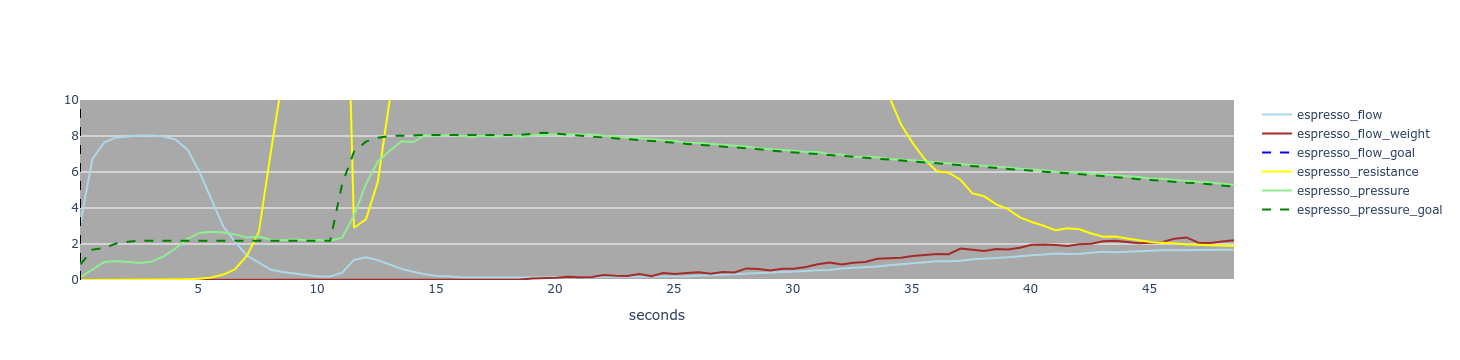

In [454]:
shots_series = extract_shot_series(shots_df.sample(1))
resampled_shots = resample(shots_series, freq='500L')
shot = resampled_shots

visualize_shot(shot,
               # flow_quantiles=flow_quantiles, weight_quantiles=weight_quantiles, pressure_quantiles=pressure_quantiles,
               )

## Models

In [455]:
models = {
    "LassoCV": linear_model.LinearRegression(),
    "DecisionTree": tree.DecisionTreeRegressor(criterion='friedman_mse', 
                                               max_depth=4, min_samples_split=15, min_samples_leaf=30, ),
    "RandomForestRegressor": ensemble.RandomForestRegressor(n_estimators=100, max_depth=4, n_jobs=-1),
    "GaussianProcessRegressor": gaussian_process.GaussianProcessRegressor(normalize_y=True),
}

for name, model in models.items():
    model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



## Evaluate

In [456]:
results = pd.DataFrame.from_dict({name: (metrics.r2_score(y_train, model.predict(X_train)), metrics.r2_score(y_test, model.predict(X_test))) \
                        for name, model in models.items()}, orient="index", columns=["Train", "Test"])
results.style.background_gradient(cmap="viridis")

,Train,Test
LassoCV,0.397473,0.431732
DecisionTree,0.482003,0.449341
RandomForestRegressor,0.540370,0.506173
GaussianProcessRegressor,0.997178,-35125.218157


## Feat importance

In [457]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(models["DecisionTree"], 
               X, y["duration"],
                target_name="duration",
                feature_names=X.columns,
                # class_names=list(iris.target_names)
               scale=1.5
              )
viz

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names



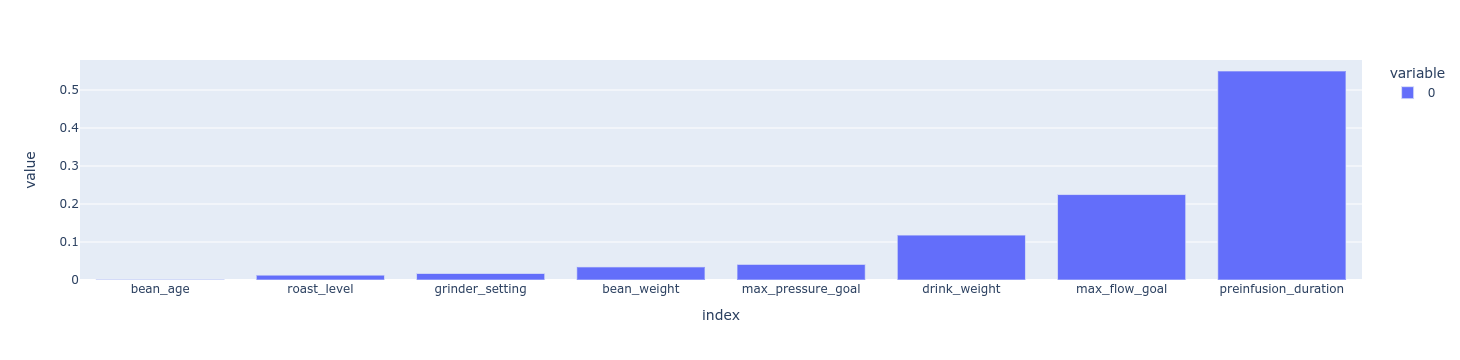

In [458]:
px.bar(pd.Series(models["RandomForestRegressor"].feature_importances_, index=X.columns).sort_values())

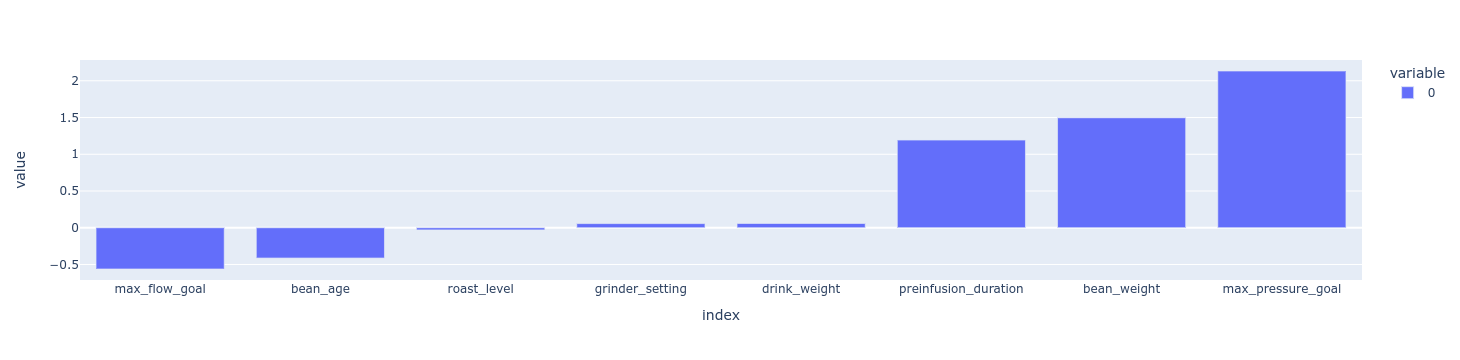

In [387]:
px.bar(pd.Series(models["LassoCV"].coef_.flatten(), index=X.columns).sort_values()).show()